In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [110]:
train_dataset = pd.read_csv('data/poem_train_data.csv')
train_dataset.head()

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [111]:
# drop na vals
train_dataset = train_dataset.dropna()
train_dataset.head()

,Genre,Poem
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...
5,Music,"for Bob Marley, Bavaria, November 1980 Here i..."


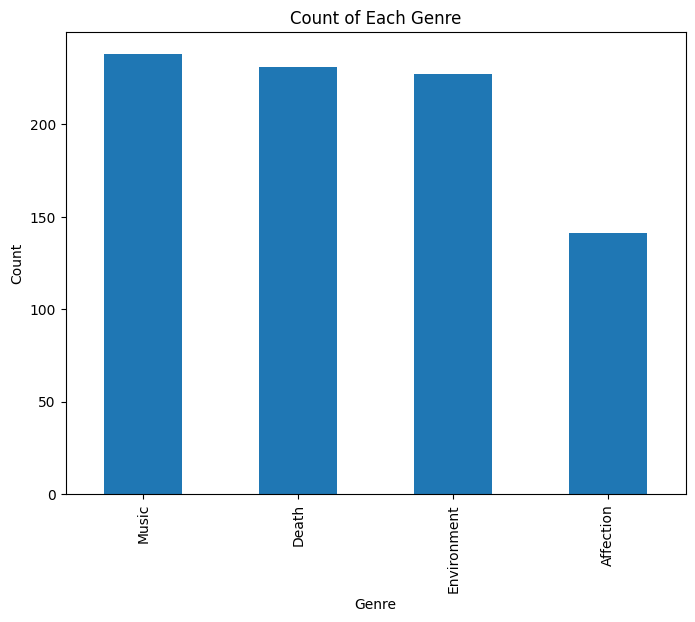

In [112]:
genre_counts = train_dataset['Genre'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
genre_counts.plot(kind='bar')

# Set title and labels
plt.title('Count of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')

# Show plot
plt.show()

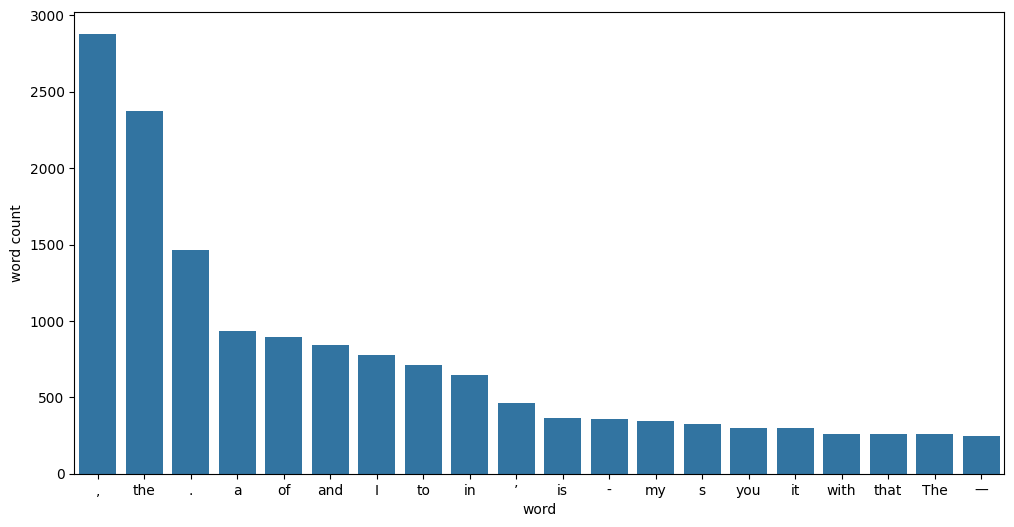

In [113]:

def get_all_words(all_text):
    all_words = ''.join([text for text in all_text])
    return all_words

def visualize_token_frequency(all_text, n_largest):
    all_words = get_all_words(all_text)
    tokenizer = tokenize.WordPunctTokenizer()
    tokenized_data = tokenizer.tokenize(all_words)
    frequency = nltk.FreqDist(tokenized_data)
    frequency_df = pd.DataFrame({
        'word': list(frequency.keys()),
        'frequency': list(frequency.values())
    })
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data = frequency_df.nlargest(n_largest, 'frequency'),
        x = 'word',
        y = 'frequency'
    )
    ax.set(ylabel = 'word count')
    plt.show()
visualize_token_frequency(train_dataset['Poem'], 20)

In [114]:
# need to get rid of punctuation and relatively meaningless words (nltk stopwords)
def clean_words(dataset, column_name, stopwords):
    remove_special_chars = re.compile(r'[^a-zA-z\s]')
    tokenizer = tokenize.WordPunctTokenizer()
    cleaned_poems = []
    for text in dataset[column_name]:
        clean_text = remove_special_chars.sub(r'', text)
        tokenized_data = tokenizer.tokenize(clean_text)
        cleaned_words = []
        for token in tokenized_data:
            token = token.lower()
            if token not in stopwords:
                cleaned_words.append(token)
        cleaned_text = ' '.join(cleaned_words)
        cleaned_poems.append(cleaned_text)
    dataset['cleaned_poems'] = cleaned_poems

stopwords = nltk.corpus.stopwords.words("english")
clean_words(train_dataset, 'Poem', stopwords)
train_dataset.head()

,Genre,Poem,cleaned_poems
1,Music,In the thick brushthey spend the...,thick brushthey spend hottest part day soaking...
2,Music,Storms are generous. ...,storms generous something easy surrender sitti...
3,Music,—After Ana Mendieta Did you carry around the ...,ana mendieta carry around matin star hold fore...
4,Music,for Aja Sherrard at 20The portent may itself ...,aja sherrard portent may memory wallace steven...
5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",bob marley bavaria november brilliant morning ...


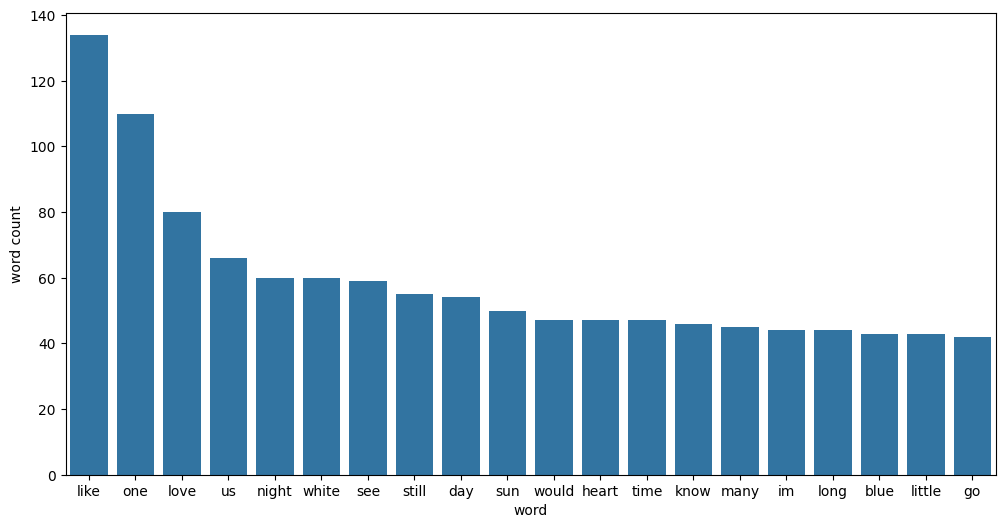

In [115]:
visualize_token_frequency(train_dataset['cleaned_poems'], 20)

In [116]:
# add stemming using nltk, ie running --> run

def stemming(dataset, column_name):
    stemmer = nltk.stem.PorterStemmer()
    tokenizer = tokenize.WordPunctTokenizer()
    stemmed_poems = []
    for text in dataset[column_name]:
        tokenized_text = tokenizer.tokenize(text)
        stemmed_tokens = []
        for token in tokenized_text:
            stemmed_tokens.append(stemmer.stem(token))
        stemmed_text = ' '.join(stemmed_tokens)
        stemmed_poems.append(stemmed_text)
    dataset['stemmed_poems'] = stemmed_poems
stemming(train_dataset, 'cleaned_poems')


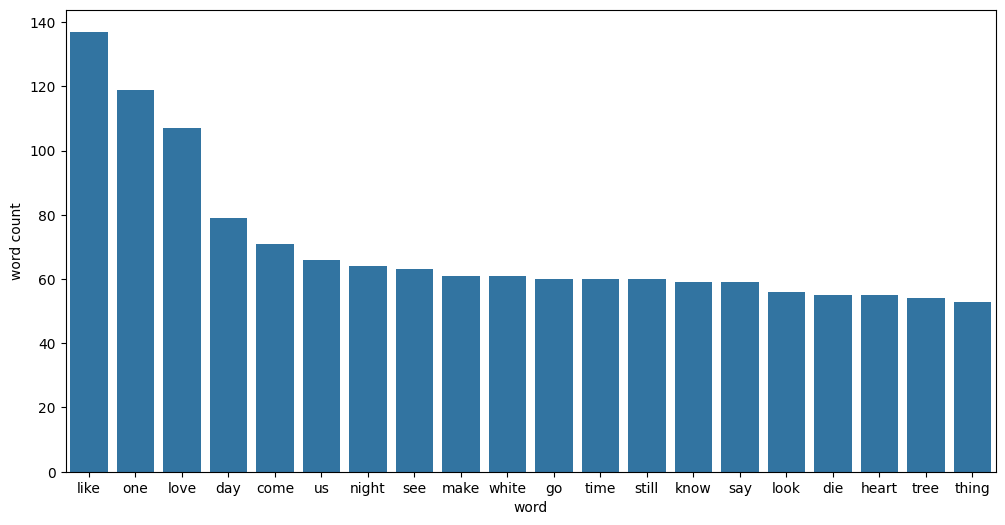

In [117]:
visualize_token_frequency(train_dataset['stemmed_poems'], 20)

In [118]:
# TF-IDF/one-hot encoding
# max_features sets top terms across all text to be used
vectorizer = TfidfVectorizer(max_features = 20)
# fit_transform turns the text into  a document-term matrix where each row represents a document, and each column represents a term.
bag_of_words = vectorizer.fit_transform(train_dataset['stemmed_poems'])
bag_of_words.shape

# now turn the bagofwords into pandas friendly
feature_names = vectorizer.get_feature_names_out()
dense_list = bag_of_words.todense().tolist()
vect_df = pd.DataFrame(dense_list, columns=feature_names)
vect_df.head()


,come,day,die,go,heart,know,like,look,love,make,night,one,say,see,still,thing,time,tree,us,white
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.755095,0.655615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# split data and train
X = bag_of_words
y = train_dataset['Genre']
# very simple Linear Regression model
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [120]:
# pre process test data
test_dataset = pd.read_csv('data/poem_test_data.csv')
test_dataset = test_dataset.dropna()
clean_words(test_dataset, 'Poem', stopwords)
stemming(test_dataset, 'cleaned_poems')
test_dataset.head()

,Genre,Poem,cleaned_poems,stemmed_poems
0,Music,A woman walks by the bench I’m sitting onwith ...,woman walks bench im sitting onwith dog looks ...,woman walk bench im sit onwith dog look part l...
1,Music,"Because I am a boy, the untouchability of beau...",boy untouchability beautyis subject already bo...,boy untouch beautyi subject alreadi book statu...
2,Music,"Because today we did not leave this world,We n...",today leave worldwe embody prominence within i...,today leav worldw embodi promin within iteven ...
3,Music,"Big Bend has been here, been here. Shouldn’t i...",big bend shouldnt saycall mountains wall must ...,big bend shouldnt saycal mountain wall must ri...
4,Music,"I put shells there, along the lip of the road....",put shells along lip roadbivalves last summers...,put shell along lip roadbivalv last summer din...


In [121]:
# test model with test data
X_test = vectorizer.transform(test_dataset['stemmed_poems'])
y_test = test_dataset['Genre']


pred = lr.predict(X_test)
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

   Affection       0.86      0.32      0.47       100
       Death       0.08      0.15      0.11        13
 Environment       0.27      0.24      0.26        25
       Music       0.13      0.75      0.23        12

    accuracy                           0.33       150
   macro avg       0.34      0.37      0.26       150
weighted avg       0.64      0.33      0.38       150



In [122]:
# trying a more complex model, RandomForestClassifier
# train
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X, y)
# test
pred = rfc.predict(X_test)
report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

   Affection       0.89      0.39      0.54       100
       Death       0.07      0.15      0.10        13
 Environment       0.22      0.20      0.21        25
       Music       0.11      0.50      0.18        12

    accuracy                           0.35       150
   macro avg       0.32      0.31      0.26       150
weighted avg       0.64      0.35      0.42       150



[Text(0, 0.5, 'Affection'),
 Text(0, 1.5, 'Death'),
 Text(0, 2.5, 'Environment'),
 Text(0, 3.5, 'Music')]

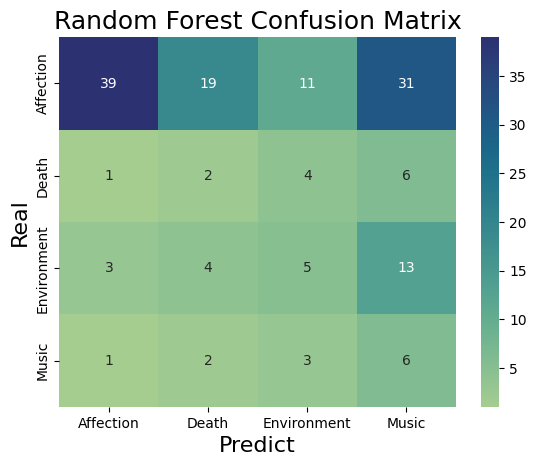

In [123]:
matrix = confusion_matrix(y_test, pred)

ax = sns.heatmap(
    matrix,
    annot = True,
    fmt = 'd',
    cmap = 'crest'
)
ax.set_title('Random Forest Confusion Matrix', fontsize = 18)
ax.set_xlabel('Predict', fontsize = 16)
ax.set_ylabel('Real', fontsize = 16)
ax.set_xticklabels(sorted(list(train_dataset['Genre'].unique())), rotation = 0)
ax.set_yticklabels(sorted(list(train_dataset['Genre'].unique())), rotation = 90)

In [124]:
# try SVM
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, train_dataset['Genre'], test_size=0.3, random_state=42)

svm_classifier = SVC(kernel='linear') # try changing kernels
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [125]:
# predictions
y_pred = svm_classifier.predict(X_test)

# results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

[[10  7  2 21]
 [ 8 17  6 38]
 [ 5 15  7 42]
 [10  9  5 50]]
              precision    recall  f1-score   support

   Affection       0.30      0.25      0.27        40
       Death       0.35      0.25      0.29        69
 Environment       0.35      0.10      0.16        69
       Music       0.33      0.68      0.44        74

    accuracy                           0.33       252
   macro avg       0.33      0.32      0.29       252
weighted avg       0.34      0.33      0.30       252

Accuracy: 0.3333333333333333
